In [42]:
# Import module
import csv
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy.stats import boxcox
from google.colab import files

In [43]:
# Upload Original Files
uploaded = files.upload()

Saving 20230317.xlsx to 20230317.xlsx


In [44]:
path_Ori = './20230317.xlsx'
file_name = './20230317.csv'

# delete big title and save to csv
def xlsx_to_csv_pd():
    data_xls = pd.read_excel(path_Ori, index_col=0, header=0)
    data_xls.to_csv(file_name, encoding='utf-8', header=None)

xlsx_to_csv_pd() # 2 csv

In [45]:
# Complete the title
with open(file_name) as f:
    data=[row for row in csv.reader(f)]

with open(file_name, 'w', encoding='utf-8') as f:
    w = csv.writer(f)
    data[0][0]="Model"
    for row in data:
        w.writerow(row)  

In [56]:
# Drop 0 in Valid-FR
import pandas as pd

file_name = './20230317.csv'
data = pd.read_csv(file_name)
filtered_data = data[data['Valid-FR'] != 0]
filtered_data.to_csv(file_name, index=False)


In [57]:
data = pd.read_csv(file_name)
data.columns = data.columns.str.replace(' ', '') # delete space
data.to_csv(file_name, encoding='utf-8', index=None)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         98 non-null     object 
 1   SPore         98 non-null     int64  
 2   CWST          98 non-null     int64  
 3   PoreSize      98 non-null     float64
 4   Flowrate(FR)  98 non-null     float64
 5   WBC(DR)       98 non-null     float64
 6   Valid-FR      98 non-null     int64  
 7   Valid-DR      98 non-null     int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.2+ KB
None
           SPore        CWST   PoreSize  Flowrate(FR)    WBC(DR)  Valid-FR  \
count  98.000000   98.000000  98.000000     98.000000  98.000000      98.0   
mean    9.744898   99.489796   4.179592      0.893869   0.940177       1.0   
std     1.730927   12.630551   0.530731      0.376455   0.117144       0.0   
min     6.000000   80.000000   3.400000      0.066667   0.320000       1.0   
25%     9.0

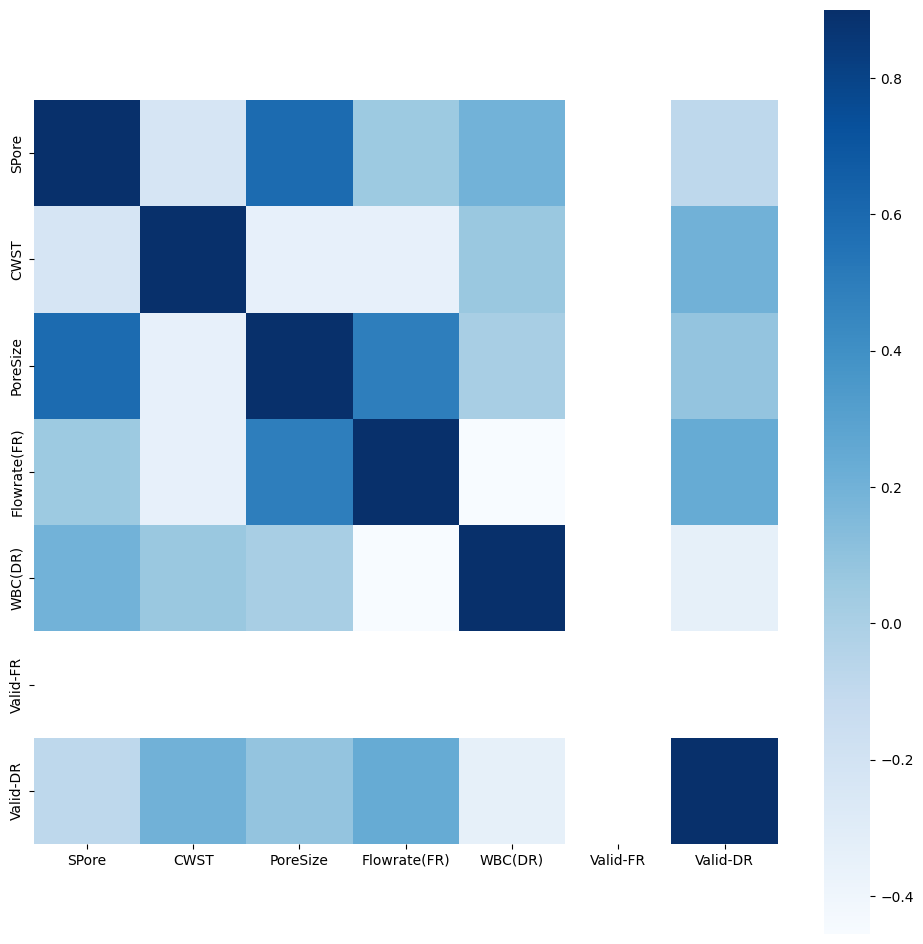

In [58]:
def draw_corr_picture(X):   # 相關係數圖
    corrmat = X.corr()
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(data)

In [59]:
# Drop L/M Pore
data = pd.read_csv(file_name)
data = data.drop(['LPore', 'MPore'], axis=1)
data.to_csv(file_name, index=False)

KeyError: ignored

In [60]:
import numpy as np

x = data[data.columns[1:4]]
y = np.ravel(data[["Flowrate(FR)"]]) # FR

x = (x - x.min()) / (x.max() - x.min())

bestfeatures = SelectKBest(score_func=f_regression, k=3)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Flowrate(FR)']  #name the data_frame columns
print(featureScores.nlargest(3, 'Flowrate(FR)'))

      Specs  Flowrate(FR)
2  PoreSize     30.751312
1      CWST     12.600964
0     SPore      0.273386


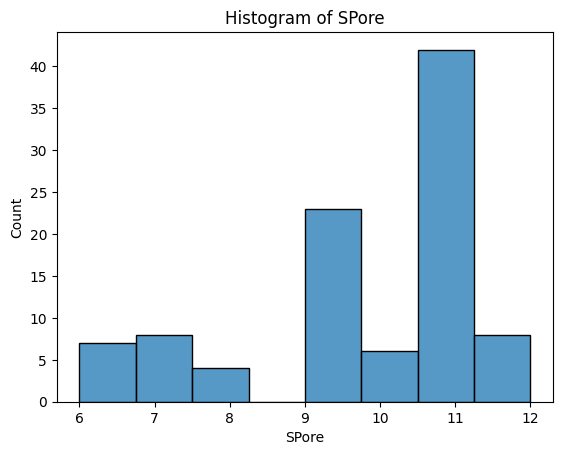

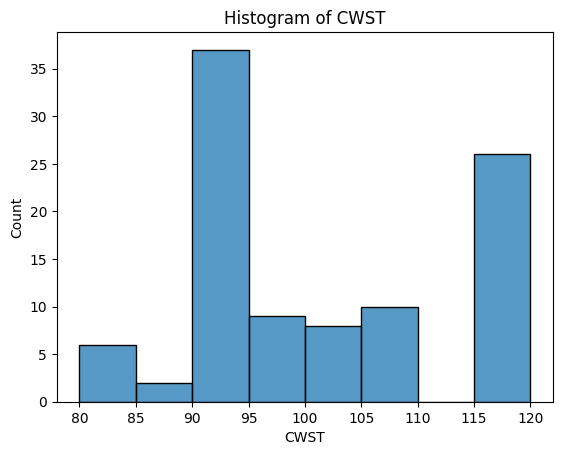

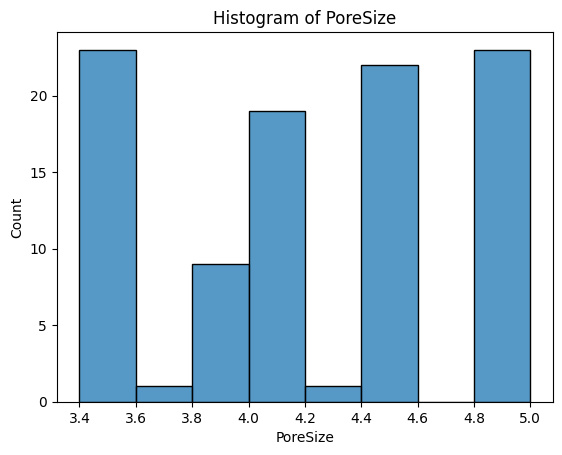

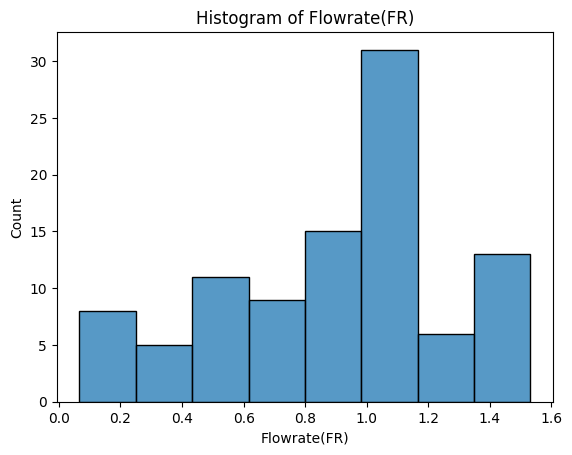

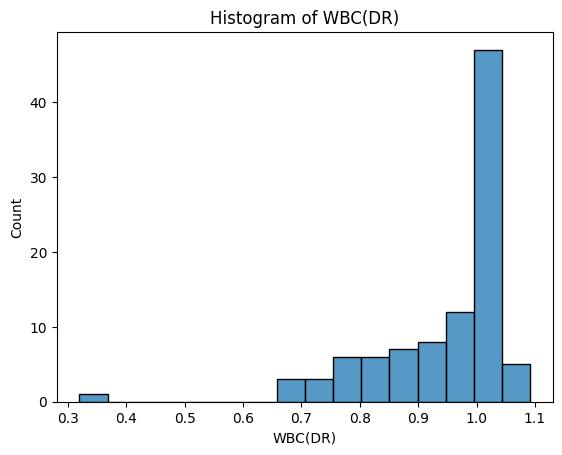

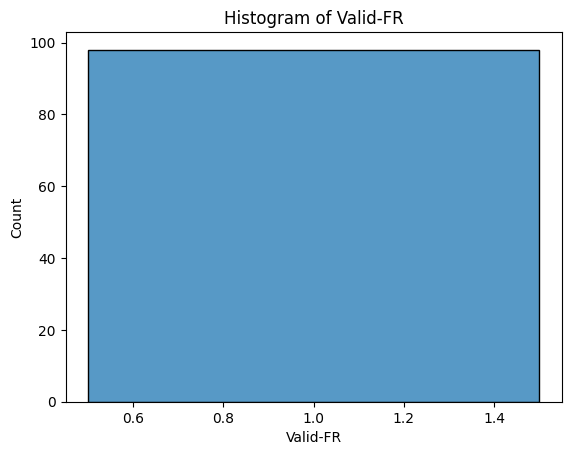

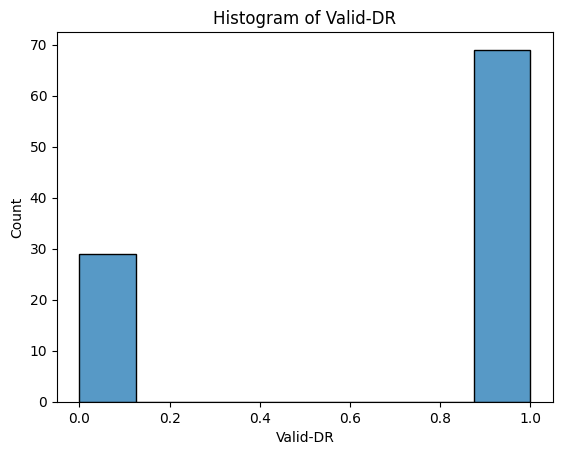

In [63]:
data = pd.read_csv(file_name)
features = data.drop(["Model"], axis=1)

for column in features.columns:
    plt.figure()
    sns.histplot(features[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

In [64]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Doing ['SPore'] ...
Doing ['CWST'] ...
Doing ['PoreSize'] ...
Doing ['SPore', 'CWST'] ...
Doing ['SPore', 'PoreSize'] ...
Doing ['CWST', 'PoreSize'] ...
Doing ['SPore', 'CWST', 'PoreSize'] ...


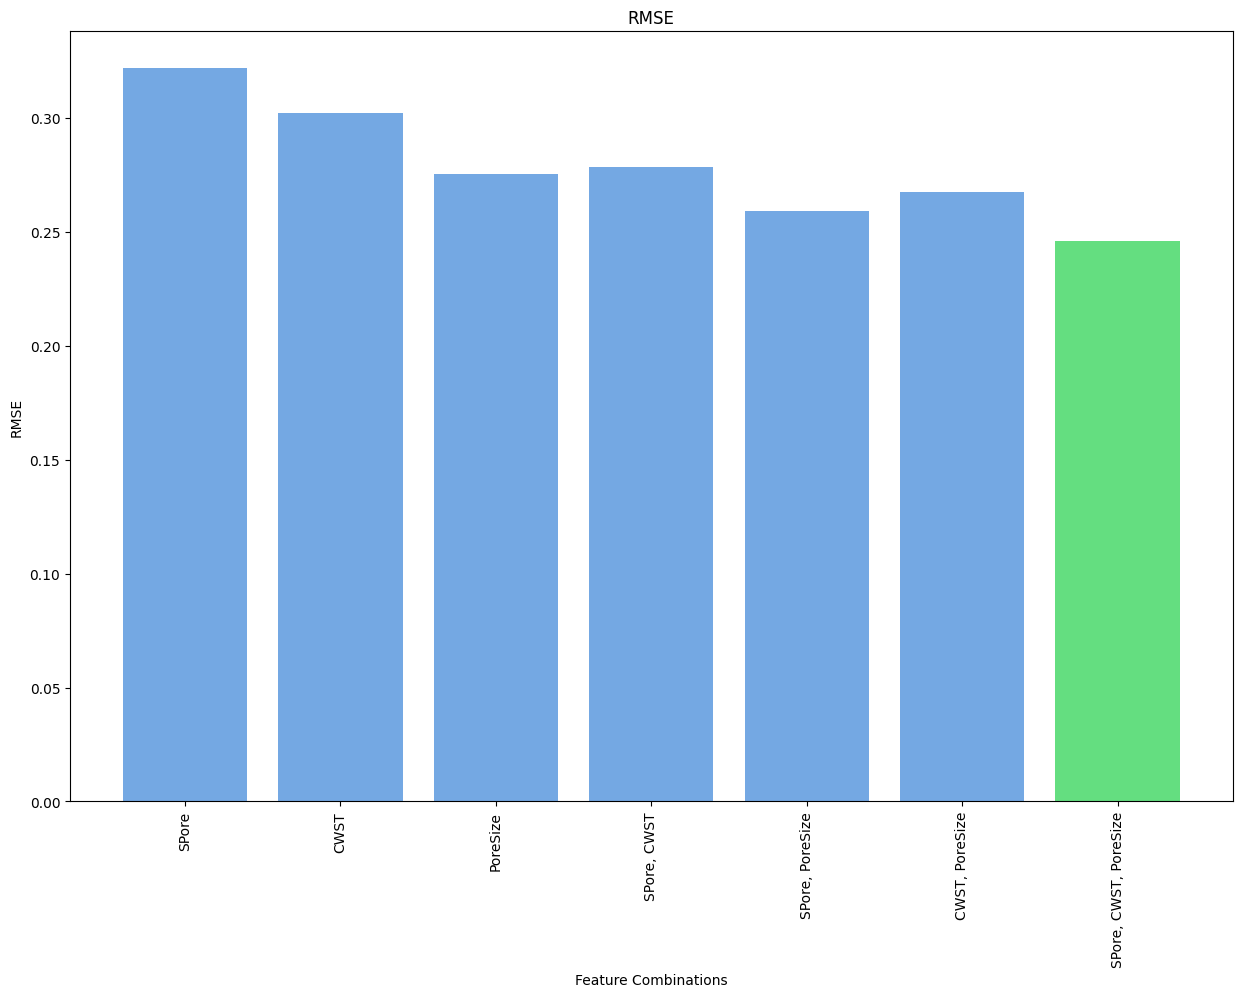

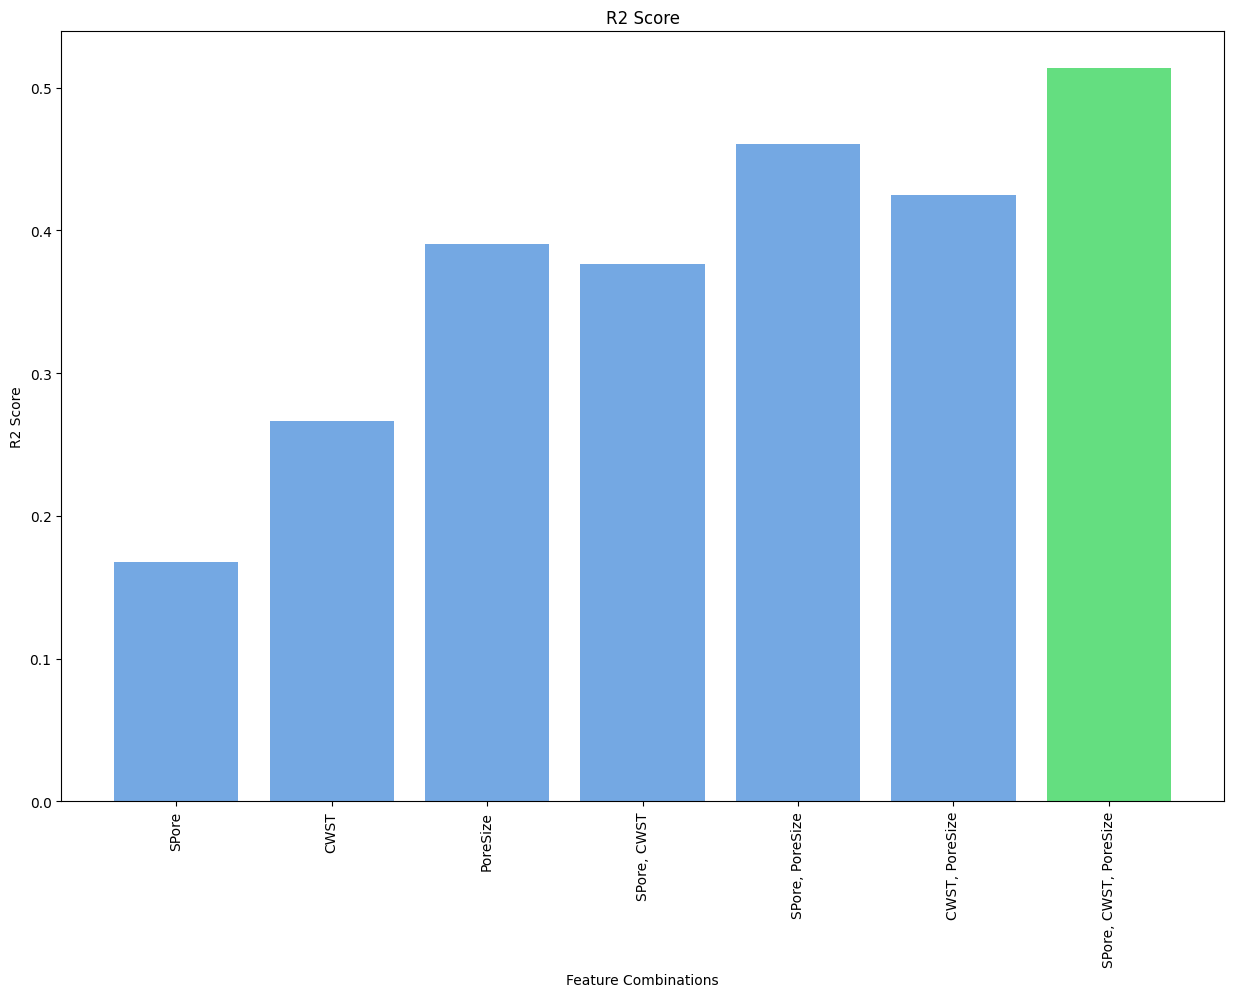

Best feature combination: ('SPore', 'CWST', 'PoreSize')
Best Root Mean squared error: 0.24609927972724321
Best R2 score: 0.5136324131712431


In [65]:
# !!!!!!! XGBoost !!!!!!!!

import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    return X, y

# Train
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, early_stopping_rounds=500)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    return model, X_test, y_test

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_model = None
    best_X_test = None
    best_y_test = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in feature_combinations:
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        model, X_test, y_test = train_model(X_comb, y)
        rmse, r2 = evaluate_model(model, X_test, y_test)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_model = model
            best_X_test = X_test
            best_y_test = y_test
    
    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_model, best_X_test, best_y_test

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_model, best_X_test, best_y_test = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_model, best_X_test, best_y_test)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()

Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:28<02:53, 28.97s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:50<02:03, 24.64s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [01:01<01:13, 18.39s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [01:10<00:44, 14.82s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [01:21<00:26, 13.32s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [01:32<00:12, 12.59s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [01:44<00:00, 14.96s/it]


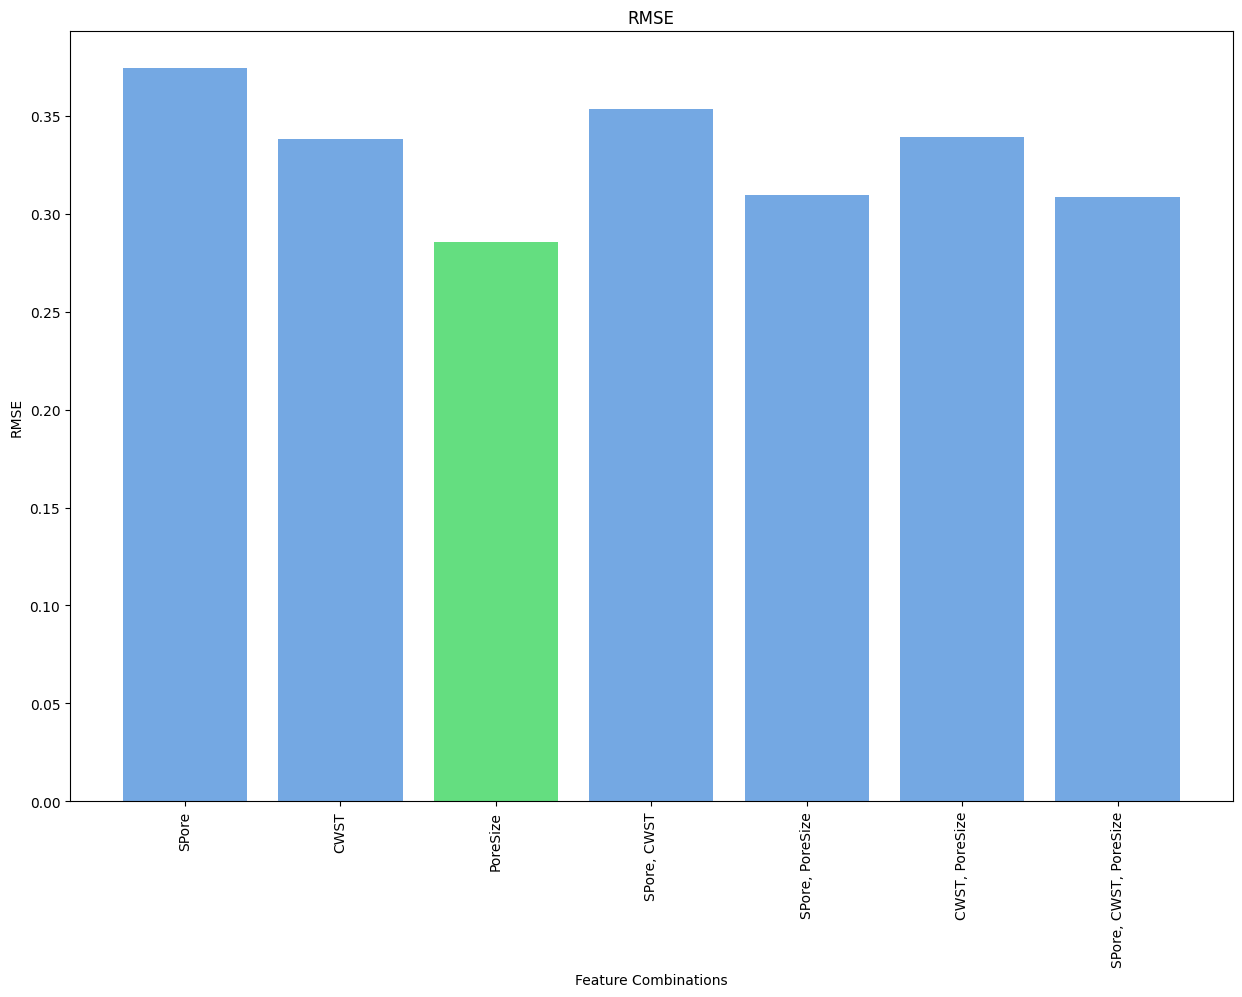

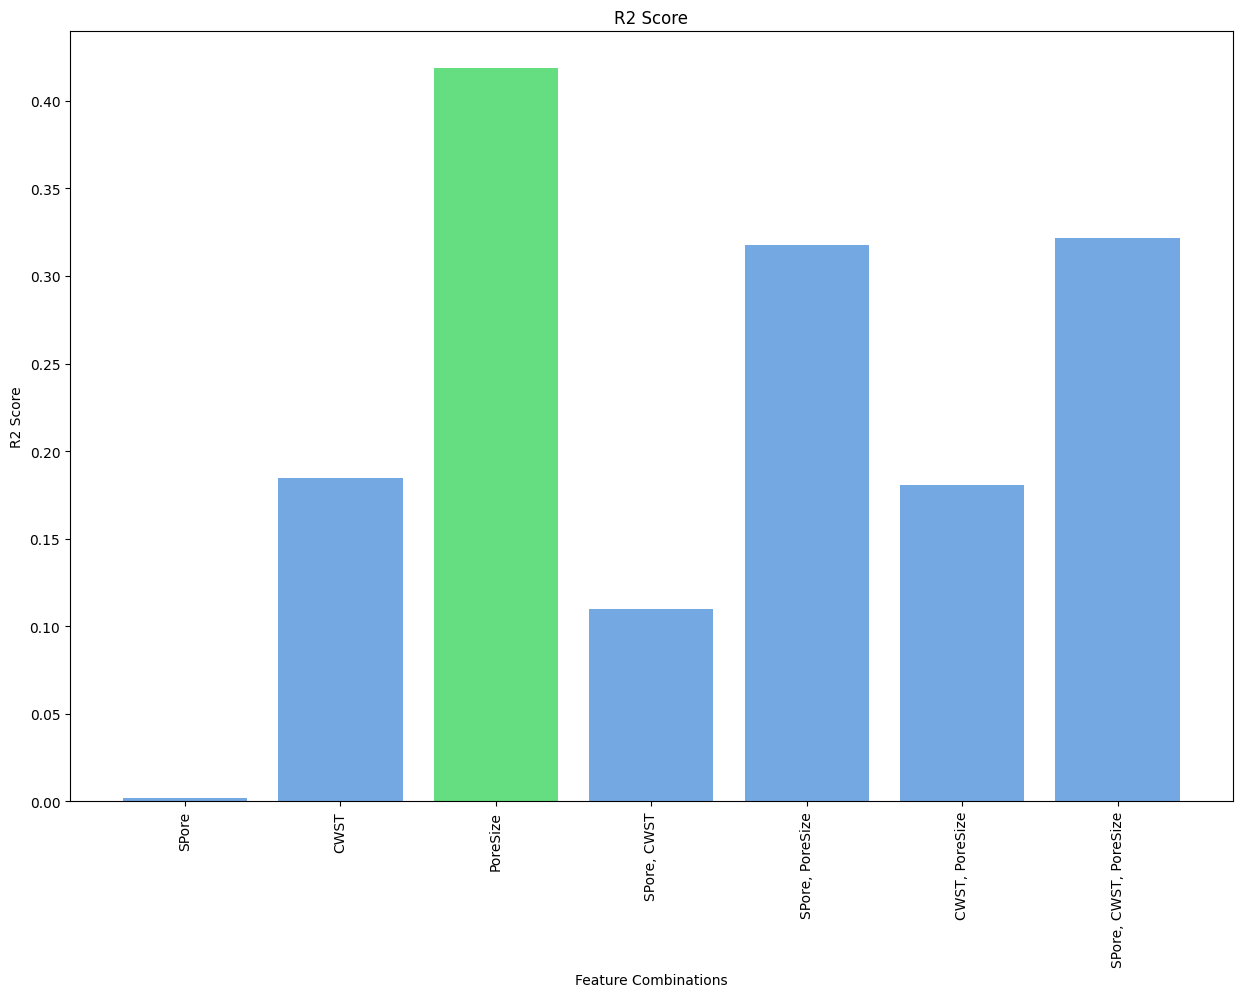

Best feature combination: ('PoreSize',)
Best Root Mean squared error: 0.285555630196481
Best R2 score: 0.4186881885195929


In [66]:
# XGBoost Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    return X, y

# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBRegressor(objective="reg:squarederror", n_estimators=500)
        model.fit(X_train, y_train, verbose=False)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()


Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:03<00:18,  3.05s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:09<00:25,  5.03s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [00:16<00:23,  5.81s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [00:38<00:36, 12.19s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [00:59<00:31, 15.56s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [01:17<00:16, 16.46s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [01:47<00:00, 15.42s/it]


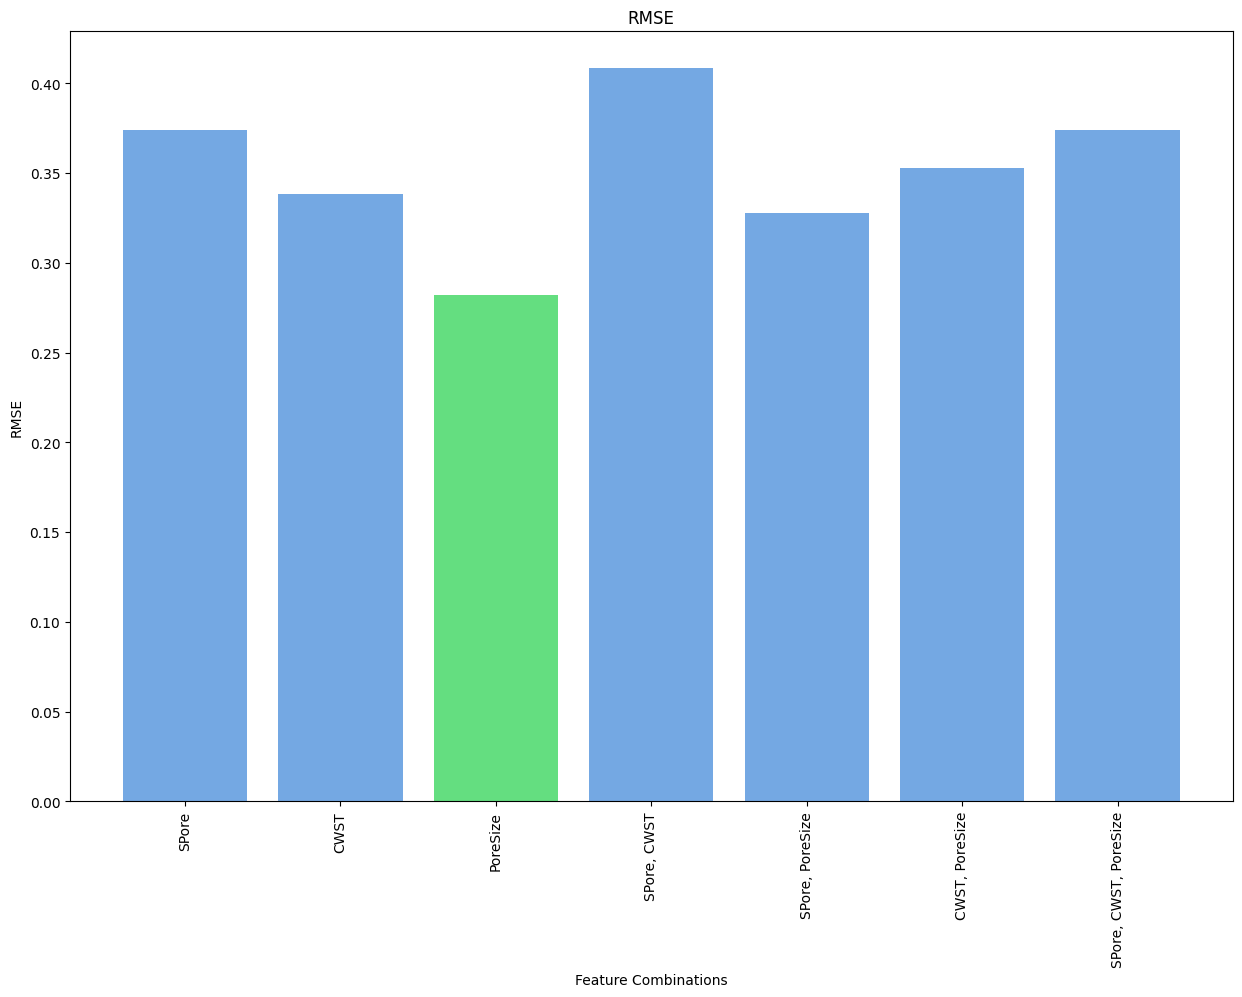

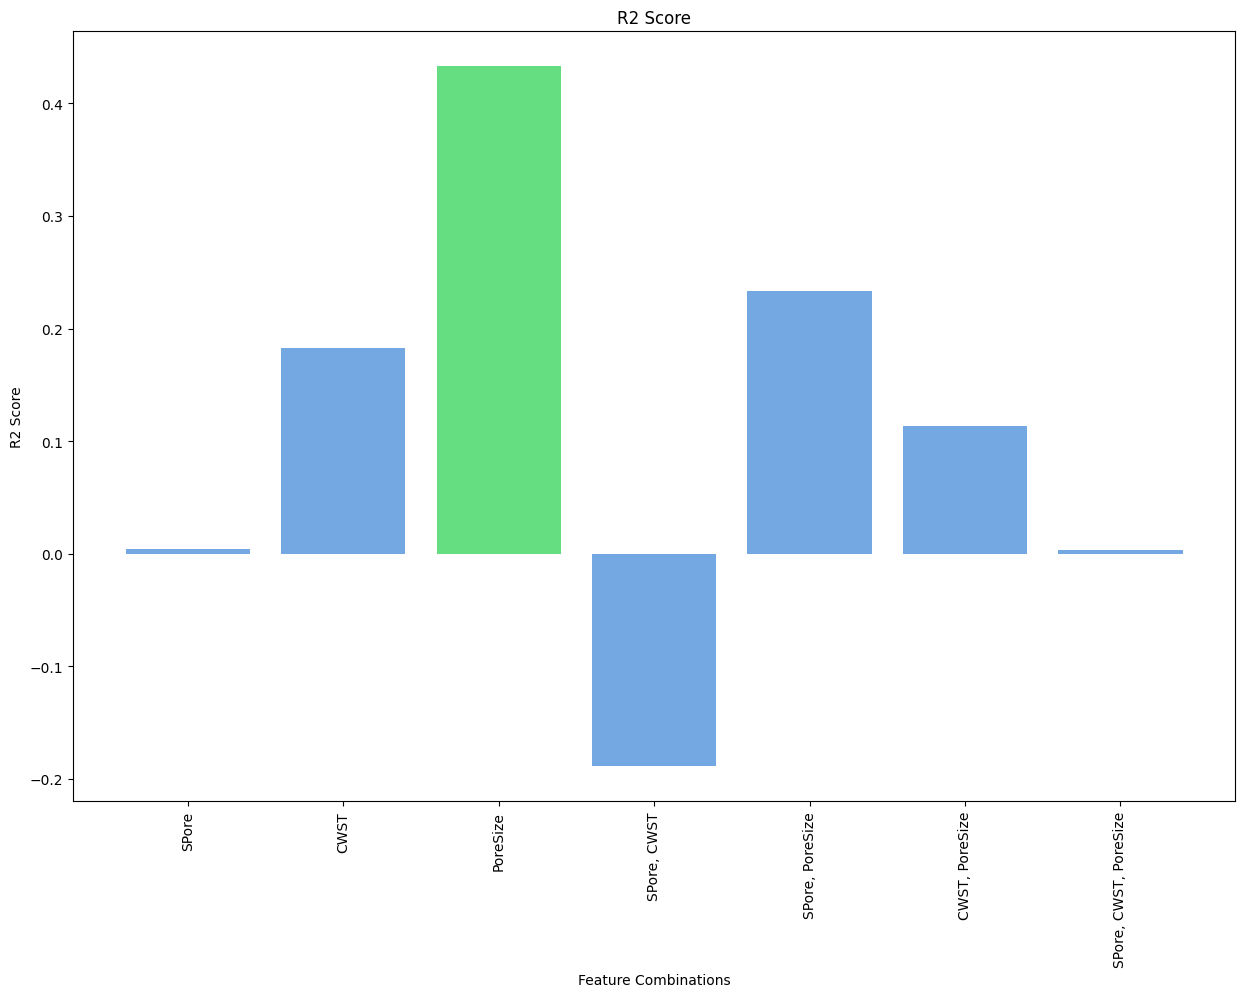

Best feature combination: ('PoreSize',)
Best Root Mean squared error: 0.2820473969571314
Best R2 score: 0.4328840206326887


In [67]:
# MLPRegressor Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    
    # Save column
    column_names = X.columns
    
    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert scaled data back to DataFrame
    X = pd.DataFrame(X, columns=column_names)

    return X, y, column_names


# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(10,10),activation="relu", solver='lbfgs', max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y, column_names = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(column_names) + 1):
        feature_combinations.extend(list(itertools.combinations(column_names, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()
